# House Prices competition on Kaggle
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques
- N.B. Evaluation is on RMSE of *logarithm* of prices

In [1]:
from IPython.display import display

In [2]:
import pandas
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy

In [3]:
#import xgboost

In [4]:
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.svm

## Loading & Basic Conversion

In [5]:
train_raw = pandas.read_csv("train.csv")
test_raw  = pandas.read_csv("test.csv")

# Any columns of type 'object' should be categories.
# Also, per data_description.txt, MSSubClass is categorical, not numerical. (?)
category_cols = [n for n,t in train_raw.dtypes.iteritems() if t == object] + ["MSSubClass"]
for c in category_cols:
    train_raw[c] = train_raw[c].astype("category")
    test_raw[c] = test_raw[c].astype("category")

### Scratch & exploration (all non-essential code):

In [6]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null category
MSZoning         1460 non-null category
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null category
Alley            91 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null category
RoofMatl         1460 non-null cat

In [7]:
train_raw.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [8]:
# See which columns contain nulls:
def summarize_nulls(df):
    null_count = df.isnull().sum()
    data = []
    for idx,count in null_count[null_count > 0].iteritems():
        percent_null = 100.0 * count / df.shape[0]
        data.append((idx, train_raw[idx].dtype, count, percent_null))
    d = pandas.DataFrame.\
        from_records(data, columns=("Feature", "Type", "NAs", "% NAs")).\
        sort_values(by="NAs", ascending=False).\
        reset_index(drop=True)
    return(d)
display(summarize_nulls(train_raw))

,Feature,Type,NAs,% NAs
0,PoolQC,category,1453,99.520548
1,MiscFeature,category,1406,96.301370
2,Alley,category,1369,93.767123
3,Fence,category,1179,80.753425
4,FireplaceQu,category,690,47.260274
5,LotFrontage,float64,259,17.739726
6,GarageType,category,81,5.547945
7,GarageYrBlt,float64,81,5.547945
8,GarageFinish,category,81,5.547945
9,GarageQual,category,81,5.547945


Notes:
- Only 7 samples have a valid `PoolQC`.
- 5 of the 7 garage-related features are present above, and all have 81 NAs. When reading the data dictionary, also note that NA actually just means "no garage" in most cases.
- The same applies to `FireplaceQu` (NA = no fireplace), `PoolQC`, `Fence`, `MiscFeature` (sort of), `Alley`, `BsmtQual`, `BsmtGotd`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `HeatingQC`
- `CentralAir` is just binary

Looking at `data-description.txt`:
- `Fence` is likely okay to treat as numerical (given the correct order).
- `PoolQC` probably is too (especially considering its sparsity)
- Likewise, `LotShape`, `KitchenQual`, `Functional`, `FireplaceQu`, `GarageFinish`, `GarageQual`, `GarageCond`, `PavedDrive`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `HeatingQC`
- `Condition1` and `Condition2` can express the same thing; likewise, `Exterior1st` and `Exterior2nd`
- `HouseStyle` is perhaps sorts of ordinal?
- `BsmtFinType1` & `BsmtFinType2`, unsure. It could be split into several vars perhaps.

#### Summarize columns (numerical, then categorical):

In [9]:
stride = 13
for t in (numpy.number, "category"):
    i = 0
    while (i + stride) < train_raw.shape[1]:
        display(train_raw.iloc[:,i:(i+stride)].describe(include=[t]))
        i += stride

,Id,LotFrontage,LotArea
count,1460.000000,1201.000000,1460.000000
mean,730.500000,70.049958,10516.828082
std,421.610009,24.284752,9981.264932
min,1.000000,21.000000,1300.000000
25%,365.750000,59.000000,7553.500000
50%,730.500000,69.000000,9478.500000
75%,1095.250000,80.000000,11601.500000
max,1460.000000,313.000000,215245.000000


,OverallQual,OverallCond,YearBuilt,YearRemodAdd
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,5.575342,1971.267808,1984.865753
std,1.382997,1.112799,30.202904,20.645407
min,1.000000,1.000000,1872.000000,1950.000000
25%,5.000000,5.000000,1954.000000,1967.000000
50%,6.000000,5.000000,1973.000000,1994.000000
75%,7.000000,6.000000,2000.000000,2004.000000
max,10.000000,9.000000,2010.000000,2010.000000


,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
count,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,103.685262,443.639726,46.549315,567.240411,1057.429452
std,181.066207,456.098091,161.319273,441.866955,438.705324
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,223.000000,795.750000
50%,0.000000,383.500000,0.000000,477.500000,991.500000
75%,166.000000,712.250000,0.000000,808.000000,1298.250000
max,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000


,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438
std,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778
min,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000
75%,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000
max,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000


,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
count,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000
mean,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137
std,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841
min,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000
25%,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000
50%,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000
75%,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000
max,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000


,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460
unique,15,5,2,2,4,4,2,5,3,25
top,20,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes
freq,536,1151,1454,50,925,1311,1459,1052,1382,225


,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType
count,1460,1460,1460,1460,1460,1460,1460,1460,1452
unique,9,8,5,8,6,8,15,16,4
top,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None
freq,1260,1445,1220,726,1141,1434,515,504,864


,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
count,1460,1460,1460,1423,1423,1422,1423,1422
unique,4,5,6,4,4,4,6,6
top,TA,TA,PConc,TA,TA,No,Unf,Unf
freq,906,1282,647,649,1311,953,430,1256


,Heating,HeatingQC,CentralAir,Electrical
count,1460,1460,1460,1459
unique,6,5,2,5
top,GasA,Ex,Y,SBrkr
freq,1428,741,1365,1334


,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond
count,1460,1460,770,1379,1379,1379,1379
unique,4,7,5,6,3,5,5
top,TA,Typ,Gd,Attchd,Unf,TA,TA
freq,735,1360,380,870,605,1311,1326


,PavedDrive,PoolQC,Fence,MiscFeature
count,1460,7,281,54
unique,3,3,4,4
top,Y,Gd,MnPrv,Shed
freq,1340,3,157,49


In [10]:
# See distributions in categorical columns:
for (name,type_) in train_raw.dtypes.iteritems():
    if type_.name == "category":
        print(train_raw[[name]].groupby(name).size())
        print()

MSSubClass
20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      58
85      20
90      52
120     87
160     63
180     10
190     30
dtype: int64

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
dtype: int64

Street
Grvl       6
Pave    1454
dtype: int64

Alley
Grvl    50
Pave    41
dtype: int64

LotShape
IR1    484
IR2     41
IR3     10
Reg    925
dtype: int64

LandContour
Bnk      63
HLS      50
Low      36
Lvl    1311
dtype: int64

Utilities
AllPub    1459
NoSeWa       1
dtype: int64

LotConfig
Corner      263
CulDSac      94
FR2          47
FR3           4
Inside     1052
dtype: int64

LandSlope
Gtl    1382
Mod      65
Sev      13
dtype: int64

Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgH

In [11]:
le = sklearn.preprocessing.LabelEncoder()
for (name,type_) in train_raw.dtypes.iteritems():
    if type_ != object: continue
    #print(name)
    # Still not quite working:
    #le.fit(train_raw[name].astype("category"))
    #train_raw[name] = le.transform(train_raw[name])

In [12]:
lr = sklearn.linear_model.LogisticRegression()
rfe = sklearn.feature_selection.RFE(lr)
# Requires above cell in order to work (needs to handle categorical vars):
#rfe = rfe.fit(train_raw.iloc[:,:-1], train_raw.iloc[:,-1])

## Conversion & Preprocessing

In [13]:
def preprocess(df):
    # CentralAir is just binary.
    # Street has two choices (gravel/paved) - so make binary StreetGravel.
    # Helper function to turn list into dictionary mapping element -> index:
    mkdict = lambda *l: dict([(el,i) for i,el in enumerate(l)])
    # Various columns are ordinal. We define (and reuse) some mappings below.
    lotshape = mkdict("Reg", "IR1", "IR2", "IR3")
    landcontour = mkdict("Lvl", "Bnk", "HLS", "Low") # not sure
    utils = mkdict("AllPub", "NoSewr", "NoSeWa", "ELO")
    slope = mkdict("Gtl", "Mod", "Sev")
    street = mkdict("Grvl", "Pave")
    alley = mkdict("NA", "Grvl", "Pave")
    qual = {"NA": -3, "Po": -2, "Fa": -1, "TA": 0, "Gd": 1, "Ex": 2}
    exp = mkdict("NA", "No", "Mn", "Av", "Gd")
    fintype = mkdict("NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ")
    elec = mkdict("Mix", "FuseP", "FuseF", "FuseA", "SBrkr")
    funct = mkdict("Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ")
    pave = mkdict("N", "P", "Y")
    fence = mkdict("NA", "MnWw", "GdWo", "MnPrv", "GdPrv")
    gf = mkdict("NA", "Unf", "RFn", "Fin")
    # Return column 'col' from df, converted according to dictionary 'dict'.
    # If 'col' contains NAs, 'null' must be set True.
    def df_get(col, dict_, null=False):
        if null:
            # To turn NA to "NA", it must be in the category levels:
            d = df[col].cat.add_categories(["NA"]).fillna("NA")
        else:
            d = df[col]
        return d.apply(lambda x: dict_[x]).astype(float)
    # Finally, start converting:
    df2 = df.assign(CentralAir = df.CentralAir == 'Y').\
        assign(Street       = df_get("Street",       street),
               Alley        = df_get("Alley",        alley, True),
               LandContour  = df_get("LandContour",  landcontour),
               LotShape     = df_get("LotShape",     lotshape),
               Utilities    = df_get("Utilities",    utils),
               LandSlope    = df_get("LandSlope",    slope),
               ExterQual    = df_get("ExterQual",    qual),
               ExterCond    = df_get("ExterCond",    qual),
               BsmtQual     = df_get("BsmtQual",     qual, True),
               BsmtCond     = df_get("BsmtCond",     qual, True),
               BsmtExposure = df_get("BsmtExposure", exp, True),
               BsmtFinType1 = df_get("BsmtFinType1", fintype, True),
               BsmtFinType2 = df_get("BsmtFinType2", fintype, True),
               HeatingQC    = df_get("HeatingQC",    qual),
               Electrical   = df_get("Electrical",   elec),
               KitchenQual  = df_get("KitchenQual",  qual),
               Functional   = df_get("Functional",   funct),
               FireplaceQu  = df_get("FireplaceQu",  qual, True),
               GarageFinish = df_get("GarageFinish", gf, True),
               GarageQual   = df_get("GarageQual",   qual, True),
               GarageCond   = df_get("GarageCond",   qual, True),
               PavedDrive   = df_get("PavedDrive",   pave),
               PoolQC       = df_get("PoolQC",       qual, True),
               Fence        = df_get("Fence",        fence, True),
              )
    return df2

train = preprocess(train_raw)
test = preprocess(test_raw)

### Examining results again after this:

In [14]:
display(summarize_nulls(train))

,Feature,Type,NAs,% NAs
0,MiscFeature,category,1406,96.301370
1,LotFrontage,float64,259,17.739726
2,GarageType,category,81,5.547945
3,GarageYrBlt,float64,81,5.547945
4,MasVnrType,category,8,0.547945
5,MasVnrArea,float64,8,0.547945
6,Electrical,category,1,0.068493


In [15]:
display(train[train.MasVnrType.isnull()][["MasVnrType", "MasVnrArea"]])
display(train[["MasVnrType"]].groupby("MasVnrType").size())

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


MasVnrType
BrkCmn      15
BrkFace    445
None       864
Stone      128
dtype: int64

In [16]:
train[train.GarageType.isnull()][["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"]].describe()

,GarageYrBlt,GarageFinish,GarageQual
count,0.0,81.0,81.0
mean,NaN,0.0,-3.0
std,NaN,0.0,0.0
min,NaN,0.0,-3.0
25%,NaN,0.0,-3.0
50%,NaN,0.0,-3.0
75%,NaN,0.0,-3.0
max,NaN,0.0,-3.0


In [17]:
display(train[["Electrical"]].groupby("Electrical").size())

Electrical
0.0       1
1.0       3
2.0      27
3.0      94
4.0    1334
dtype: int64

In [18]:
# Examine street-related features with the NAs in LotFrontage:
train[["LotFrontage", "LotArea", "LotShape", "Street", "Condition1", "Condition2"]][train.LotFrontage.isnull()].describe(include='all')

,LotFrontage,LotArea,LotShape,Street,Condition1,Condition2
count,0.0,259.000000,259.000000,259.000000,259,259
unique,NaN,NaN,NaN,NaN,9,3
top,NaN,NaN,NaN,NaN,Norm,Norm
freq,NaN,NaN,NaN,NaN,223,257
mean,NaN,13137.370656,0.795367,0.996139,NaN,NaN
std,NaN,16215.264451,0.591131,0.062137,NaN,NaN
min,NaN,1974.000000,0.000000,0.000000,NaN,NaN
25%,NaN,8065.500000,0.000000,1.000000,NaN,NaN
50%,NaN,10624.000000,1.000000,1.000000,NaN,NaN
75%,NaN,13018.500000,1.000000,1.000000,NaN,NaN


Notes on the remaining NAs:
- `MiscFeature`: NA means the lack of any feature. Encoding should handle this.
- `GarageType` and `GarageYrBlt` are NA for the lack of a garage.
- The single NA in `Electrical` can probably be set to `SBrkr`
- `MasVnrType` and `MasVnrArea` are NA together, and perhaps can be set to `None` (the mode) given how few examples this applies to.
- `LotFrontage`: No apparent order in this. Replacing with 0 might be okay.

In [19]:
def fill_missing(df):
    miscfeatures = pandas.get_dummies(df.MiscFeature, prefix="MiscFeature")
    df2 = pandas.concat([df, miscfeatures], axis=1).\
        assign(Electrical = df.Electrical.fillna("SBrkr"),
               MasVnrType = df.MasVnrType.fillna("None"),
               MasVnrArea = df.MasVnrArea.fillna(0.0),
               LotFrontage = df.LotFrontage.fillna(0.0),
              ).\
        drop("MiscFeature", axis=1)
    # GarageType, GarageYrBit
    return df2

train = fill_missing(train)
test = fill_missing(test)

In [20]:
display(summarize_nulls(train))

,Feature,Type,NAs,% NAs
0,GarageType,category,81,5.547945
1,GarageYrBlt,float64,81,5.547945


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
Id                  1460 non-null int64
MSSubClass          1460 non-null category
MSZoning            1460 non-null category
LotFrontage         1460 non-null float64
LotArea             1460 non-null int64
Street              1460 non-null float64
Alley               1460 non-null float64
LotShape            1460 non-null float64
LandContour         1460 non-null float64
Utilities           1460 non-null float64
LotConfig           1460 non-null category
LandSlope           1460 non-null float64
Neighborhood        1460 non-null category
Condition1          1460 non-null category
Condition2          1460 non-null category
BldgType            1460 non-null category
HouseStyle          1460 non-null category
OverallQual         1460 non-null int64
OverallCond         1460 non-null int64
YearBuilt           1460 non-null int64
YearRemodAdd        1460 non-null int64
RoofStyle      

In [22]:
cols_numerical = list(train.select_dtypes((numpy.number,)).columns)
for c in ("GarageYrBlt", "Id", "SalePrice"):
    cols_numerical.remove(c)

In [23]:
train_X = train[cols_numerical]
train_Y = train["SalePrice"]
imp = sklearn.feature_selection.mutual_info_classif(train_X, train_Y)
mutual_info = pandas.DataFrame({"Feature": cols_numerical}).\
    assign(Importance=imp).\
    sort_values("Importance", ascending=False).\
    reset_index(drop=True)
mutual_info.head(15)

,Feature,Importance
0,Street,3.772142
1,KitchenAbvGr,3.632524
2,PavedDrive,3.537395
3,BsmtFinType2,2.659816
4,FullBath,2.594939
5,GarageCars,2.194846
6,Functional,1.961898
7,BsmtExposure,1.698486
8,PoolQC,1.457526
9,GarageFinish,1.150398


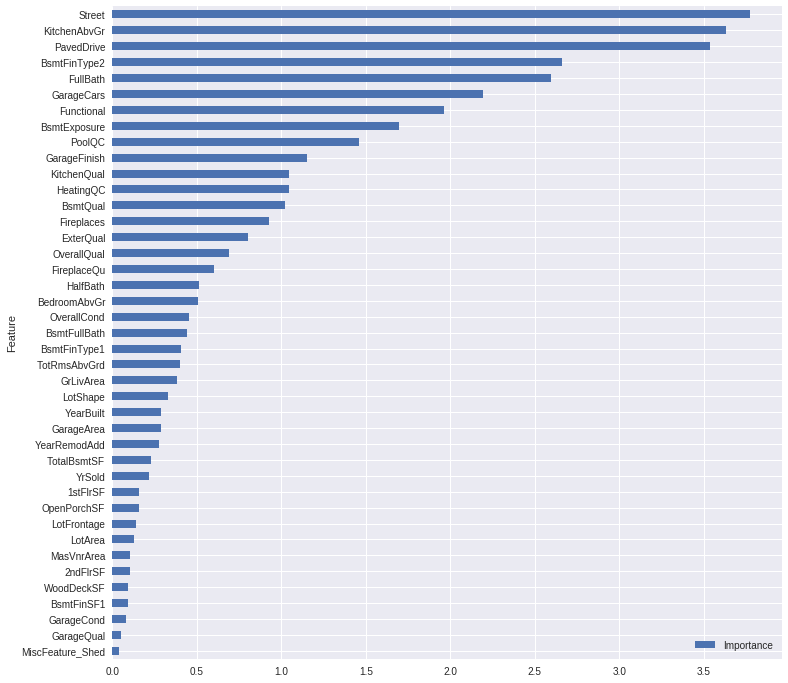

In [25]:
%matplotlib inline
fig = mutual_info.iloc[40::-1,:].plot.barh(x="Feature", y="Importance", figsize=(12,12))

To do:
- Look at categorical variables
- Fill NAs (somehow) in Garage-related vars